# <font style="color: rgb(0,0,0);">Joined Model</font> <font style="color: rgb(190,138,67);">Relevance Comparison</font>

In [1]:
# imports
import numpy as np
import xarray as xr
import cv2
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from tqdm.notebook import tqdm

inferno = cm.get_cmap('inferno', 256)
newcolors = inferno(np.linspace(0, 1, 256))
revinferno = ListedColormap(np.flip(newcolors,axis=0))

In [2]:
from A_helper_functions import *

In [3]:
# A Result
ISRU_data = xr.open_dataarray("maps/ISRU_COST_GLOBAL.nc").data
info(ISRU_data)

float32 (13680, 27360) data range: 17054.625 - 157718.5


In [4]:
# B Results
spent_fuel_NRHO_1_5 = xr.open_dataarray("maps/spent_fuel_NRHO_1_5.nc").data
spent_fuel_NRHO_2_5  = xr.open_dataarray("maps/spent_fuel_NRHO_2_5.nc").data
info(spent_fuel_NRHO_1_5)
info(spent_fuel_NRHO_2_5)

float64 (9, 18) data range: 2.166410998493994 - 4.5961265323240035
float64 (9, 18) data range: 1.8218499158200014 - 3.4727174727400065


In [5]:
# match resolution to be able to combine data
dsize = (2000,1000)

In [6]:
# upscale dv_data
spent_fuel_NRHO_1_5_resized = cv2.resize(spent_fuel_NRHO_1_5, dsize=dsize, interpolation=cv2.INTER_LINEAR)
spent_fuel_NRHO_2_5_resized = cv2.resize(spent_fuel_NRHO_2_5, dsize=dsize, interpolation=cv2.INTER_LINEAR)
info(spent_fuel_NRHO_1_5_resized)
info(spent_fuel_NRHO_2_5_resized)

float64 (1000, 2000) data range: 2.166410998493994 - 4.5961265323240035
float64 (1000, 2000) data range: 1.8218499158200014 - 3.4727174727400065


In [7]:
ISRU_data_resized = cv2.resize(ISRU_data, dsize=dsize, interpolation=cv2.INTER_NEAREST)
info(ISRU_data_resized) 

float32 (1000, 2000) data range: 17054.625 - 157718.5


In [ ]:
# visual inspection of downsampled vs original data
plot_map(ISRU_data_resized,1,'ISRU Cost [kg]',(-90,90),(-180,180),i_steps=[],silent=True,labelsize=18)

In [ ]:
plot_map(ISRU_data,1,'ISRU Cost [kg]',(-90,90),(-180,180),i_steps=[],silent=True,labelsize=18)

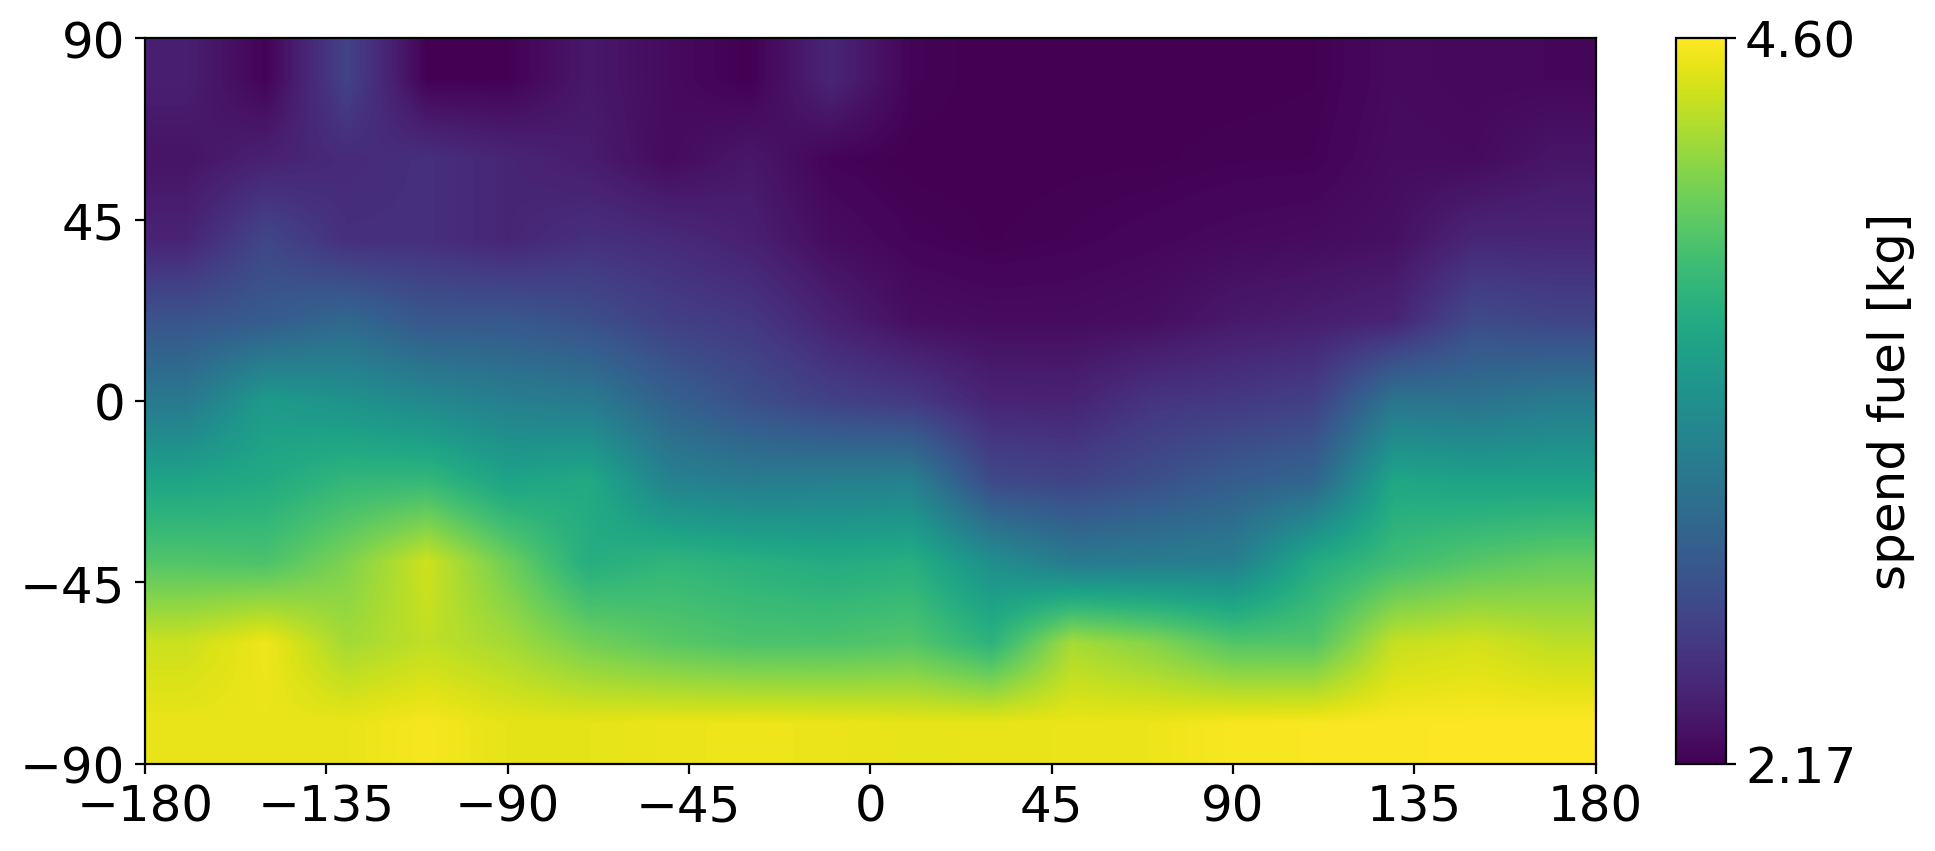

In [24]:
# visual inspection of upsampled vs original data
plot_map(spent_fuel_NRHO_1_5_resized,1,'spend fuel [kg]',(-90,90),(-180,180),i_steps=[],silent=True,labelsize=18)

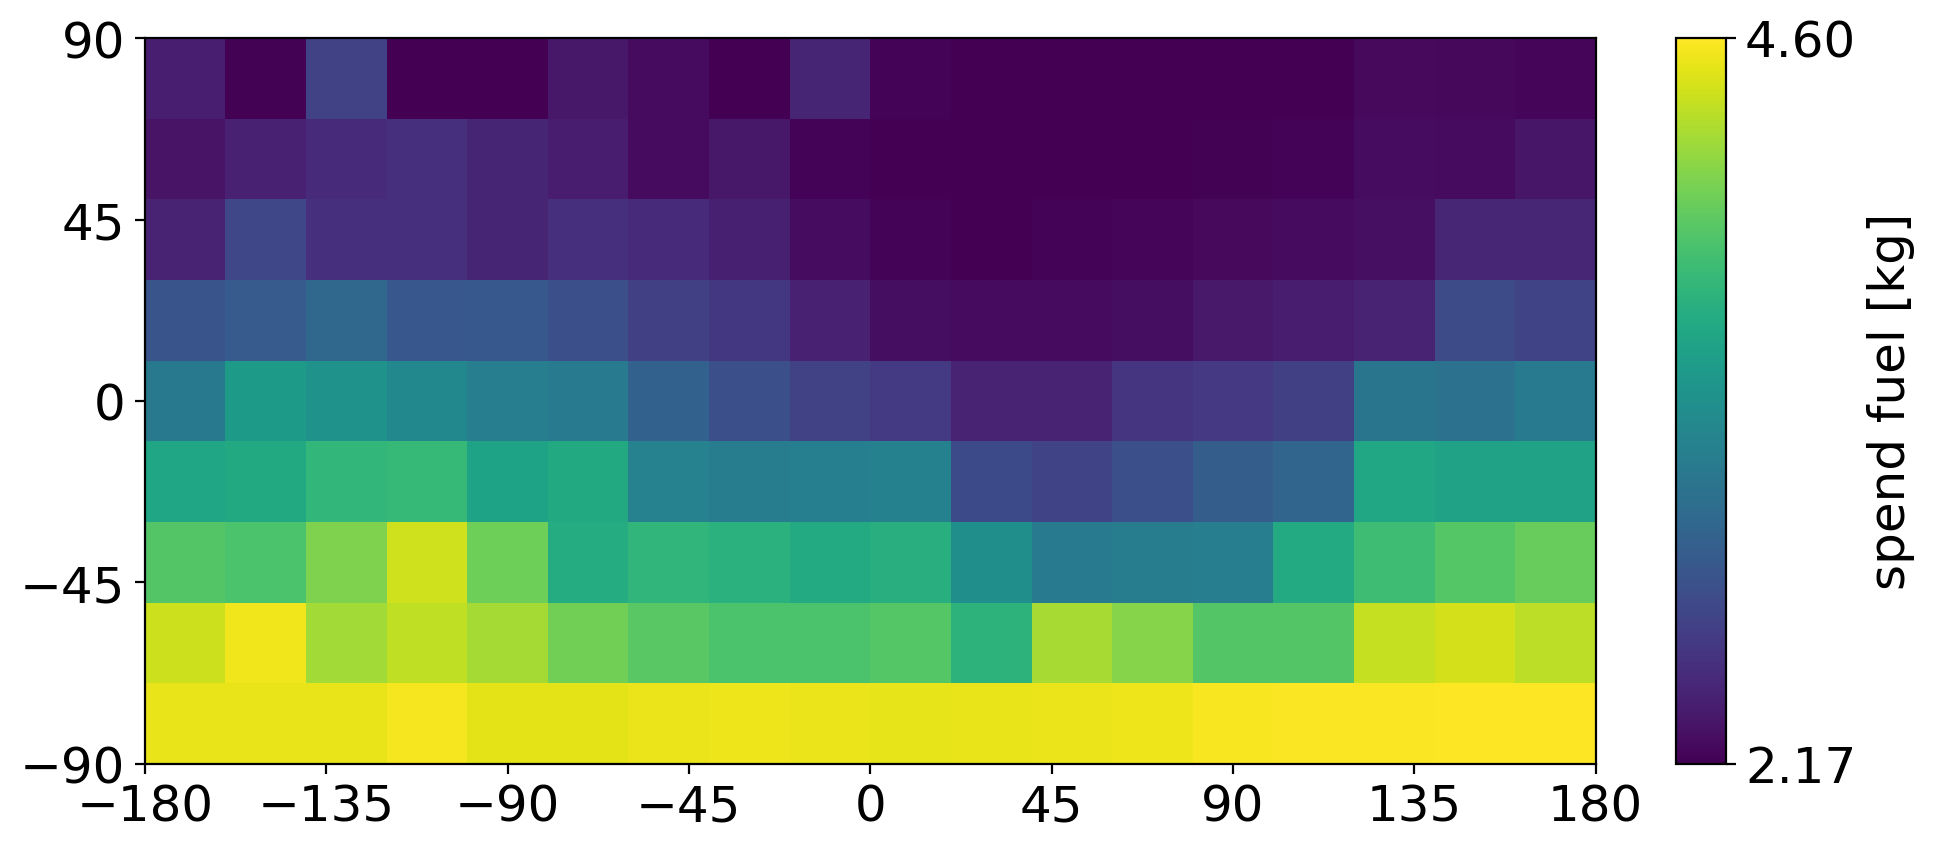

In [25]:
plot_map(spent_fuel_NRHO_1_5,1,'spend fuel [kg]',(-90,90),(-180,180),i_steps=[],silent=True,labelsize=18)

## Combined Model

### SIMPLE
assuming all spend fuel masses to be cost

In [11]:
# cost_per_kg_payload = (used_O2 + used_H2) / payload
# Total costs = ISRU_costs + t [years] * m_payload_per_year * cost_per_kg_payload

In [12]:
m_payload_per_year = 23.9 * 1000

def total_costs_simple_1_5(years):
    res = ISRU_data_resized + years * m_payload_per_year * spent_fuel_NRHO_1_5
    return res

def total_costs_simple_2_5(years):
    res = ISRU_data_resized + years * m_payload_per_year * spent_fuel_NRHO_2_5
    return res

In [13]:
Total_cost_map_simple_1_5 = total_costs_simple_1_5(20)

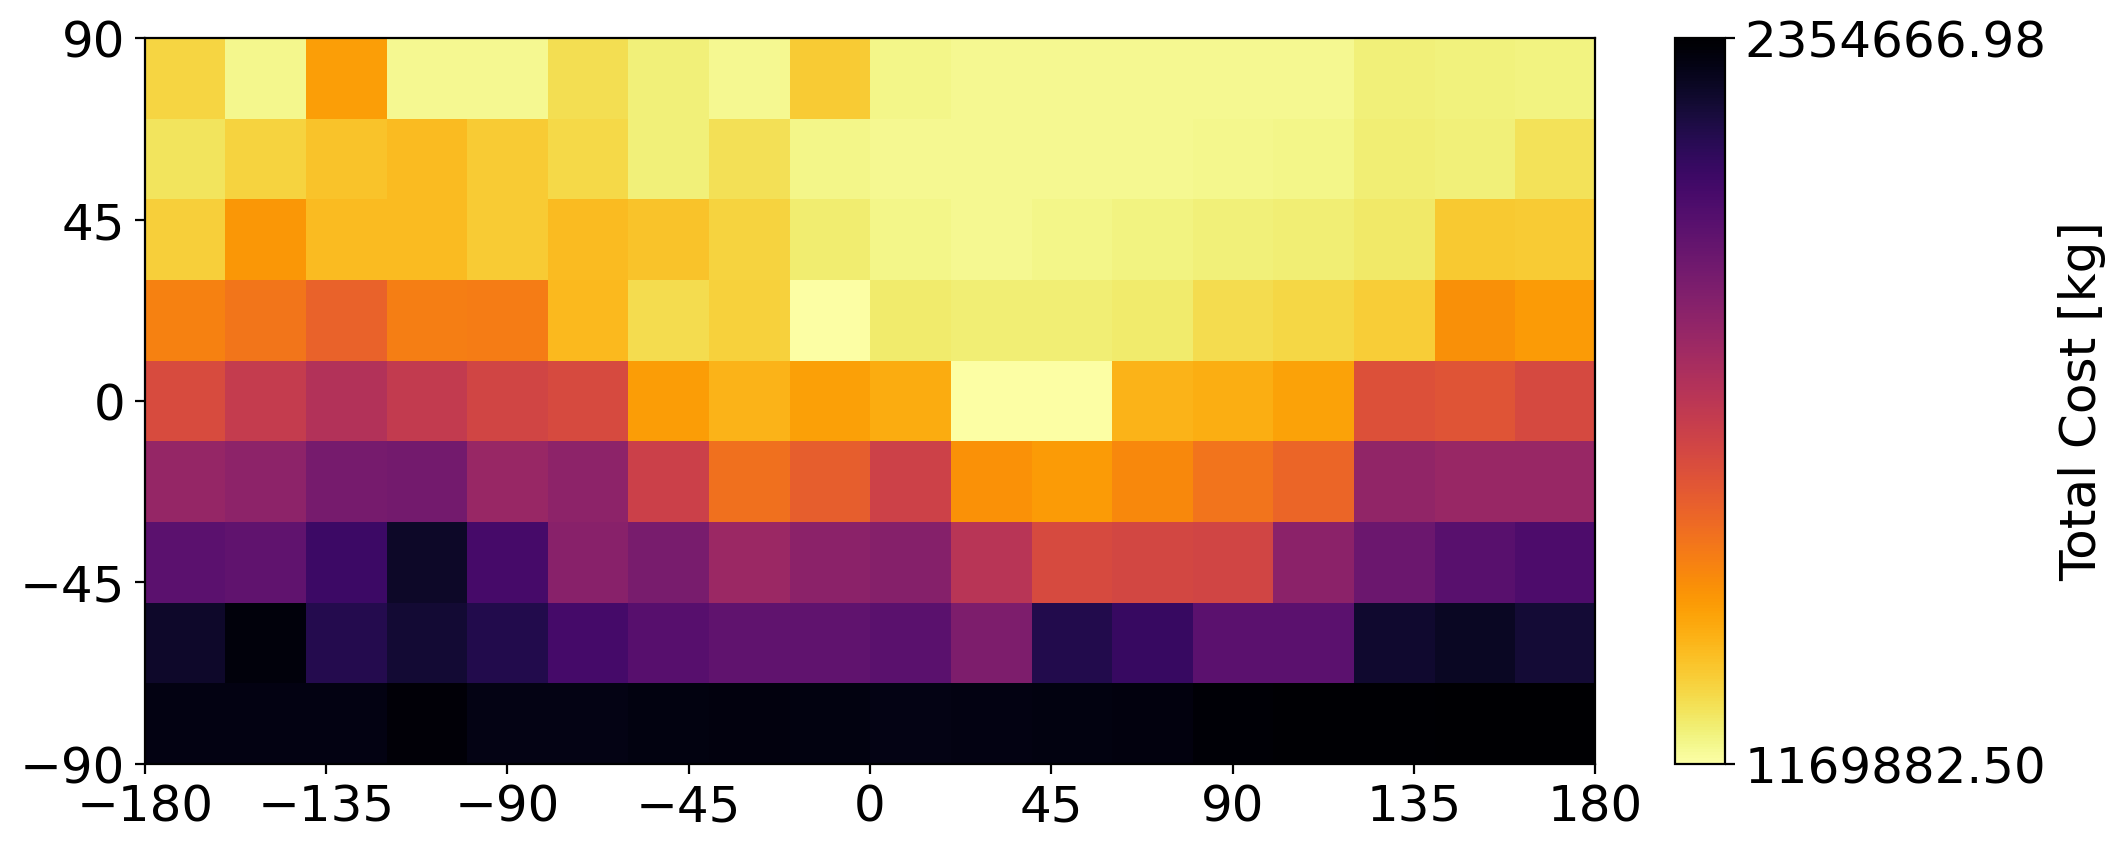

In [14]:
plot_map(Total_cost_map_simple_1_5,1,'Total Cost [kg]',(-90,90),(-180,180),cmap=revinferno,i_steps=[],silent=True,labelsize=18,save="Total_NRHO_1_5.png")

In [15]:
Total_cost_map_simple_2_5 = total_costs_simple_2_5(20)

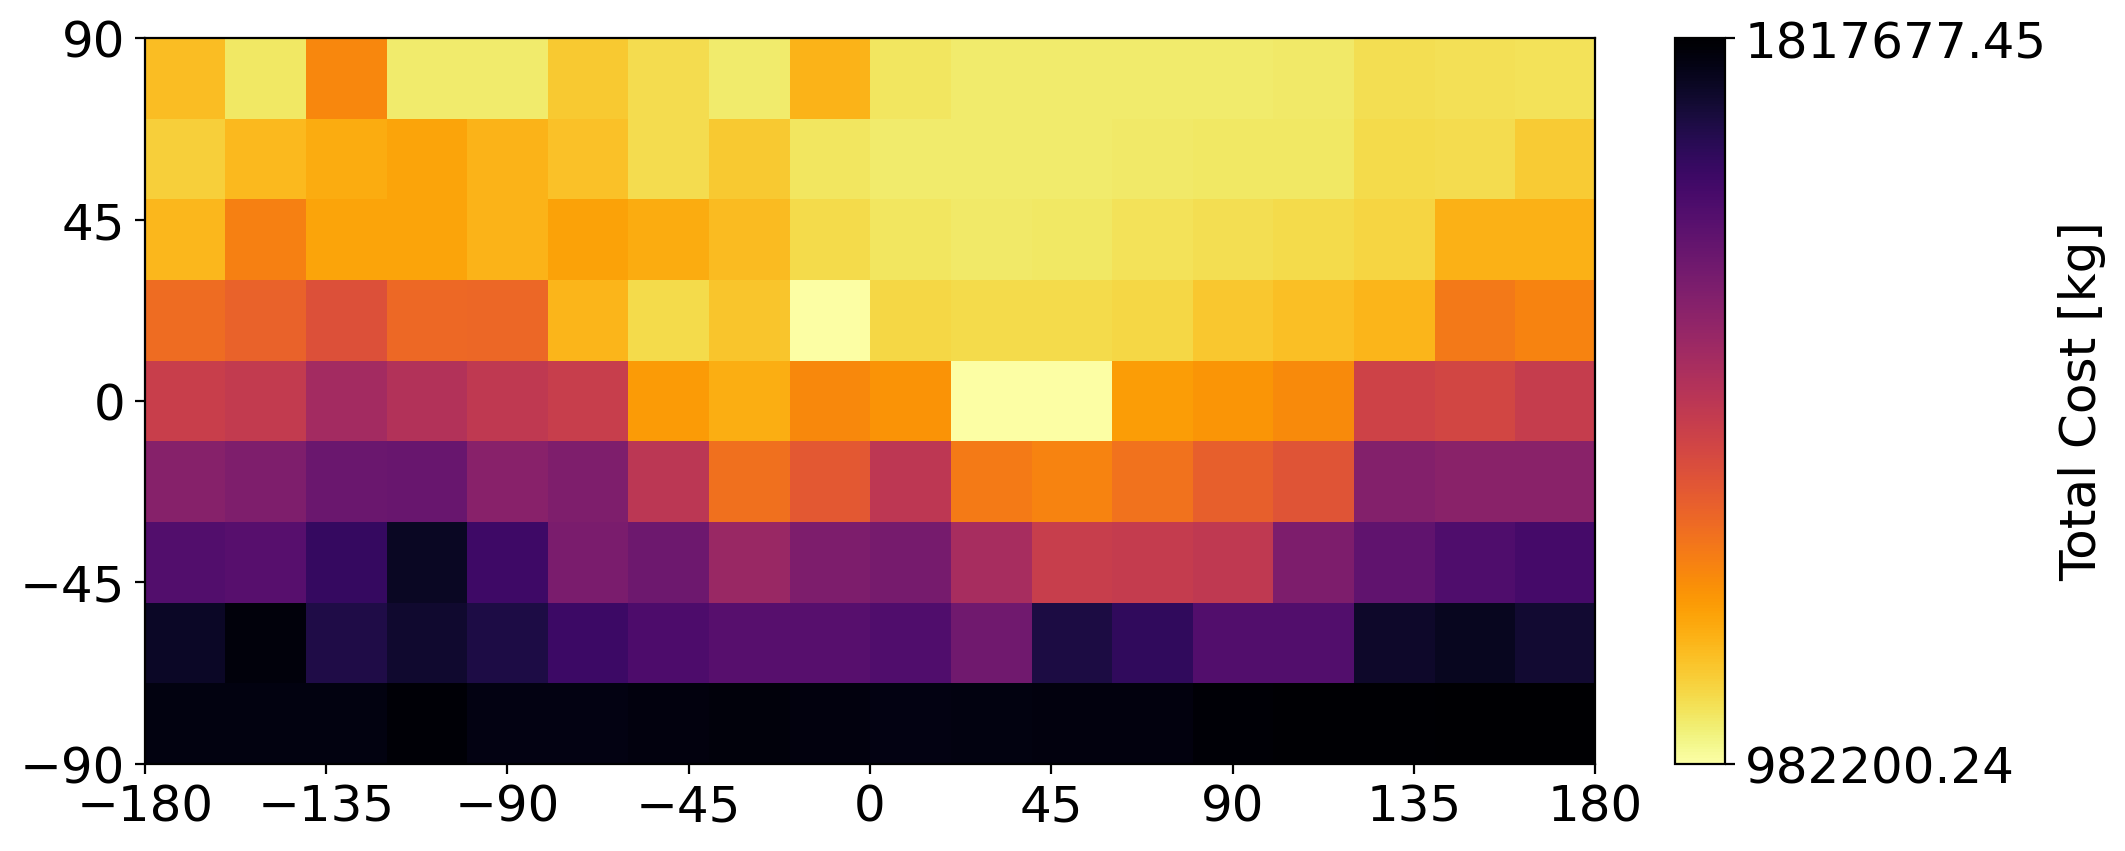

In [16]:
plot_map(Total_cost_map_simple_2_5,1,'Total Cost [kg]',(-90,90),(-180,180),cmap=revinferno,i_steps=[],silent=True,labelsize=18,save="Total_NRHO_2_5.png")

### Result - SIMPLE

with 1.25 exchange ratio (R = 9.364)
- even after 10 years of operation the transport costs did not change the landscape of preferred areas
- significant influence visible at around 100 years (still mare region optimal)

with 1.5 exchange ratio (R = 11.724)
- transport influence even less pronounced than with 1.25 exchange ratio (due to lower level of costs)

## ADVANCED
assuming: cost = H2 fuel mass cost + extra mass for ISRU to match higher O2 demand

In [8]:
# advanced - assuming H2 fuel mass cost + extra mass for ISRU to match higher O2 demand

# cost_per_kg_payload = used_H2 + additional_ISRU_mass(used_O2_per_year)
# Total costs = ISRU_costs + t [years] * m_payload_per_year * cost_per_kg_payload

In [9]:
# ISRU mass per additional kg of Oxygen per year
ISRU_mass_per_kg = ISRU_data_resized / (23.9 * 1000)

In [10]:
m_payload_per_year = 7.5 * 1000 # [kg]
m_ISRU_base_prod_per_year = 23.9 * 1000 # [kg]

of_ratio = 6
O2_factor = (of_ratio/(of_ratio+1))
H2_factor = (1/(of_ratio+1))

def total_costs_advanced_1_5(years, return_splits=False):
    spend_O2_per_year = m_payload_per_year * spent_fuel_NRHO_1_5_resized * O2_factor
    m_ISRU_additional = spend_O2_per_year + m_payload_per_year - m_ISRU_base_prod_per_year
    fix_costs_additionally = ISRU_mass_per_kg * m_ISRU_additional
    
    dynamic_costs_H2 = years * m_payload_per_year * spent_fuel_NRHO_1_5_resized * H2_factor
    
    res = ISRU_data_resized + fix_costs_additionally + dynamic_costs_H2
    
    if return_splits:
        return ISRU_data_resized + fix_costs_additionally, dynamic_costs_H2
    else:
        return res

def total_costs_advanced_2_5(years, return_splits=False):
    spend_O2_per_year = m_payload_per_year * spent_fuel_NRHO_2_5_resized * O2_factor
    m_ISRU_additional = spend_O2_per_year + m_payload_per_year - m_ISRU_base_prod_per_year
    fix_costs_additionally = ISRU_mass_per_kg * m_ISRU_additional
    
    dynamic_costs_H2 = years * m_payload_per_year * spent_fuel_NRHO_2_5_resized * H2_factor
    
    res = ISRU_data_resized + fix_costs_additionally + dynamic_costs_H2
    
    if return_splits:
        return ISRU_data_resized + fix_costs_additionally, dynamic_costs_H2
    else:
        return res

In [11]:
Total_cost_map_advanced_1_5 = total_costs_advanced_1_5(20)

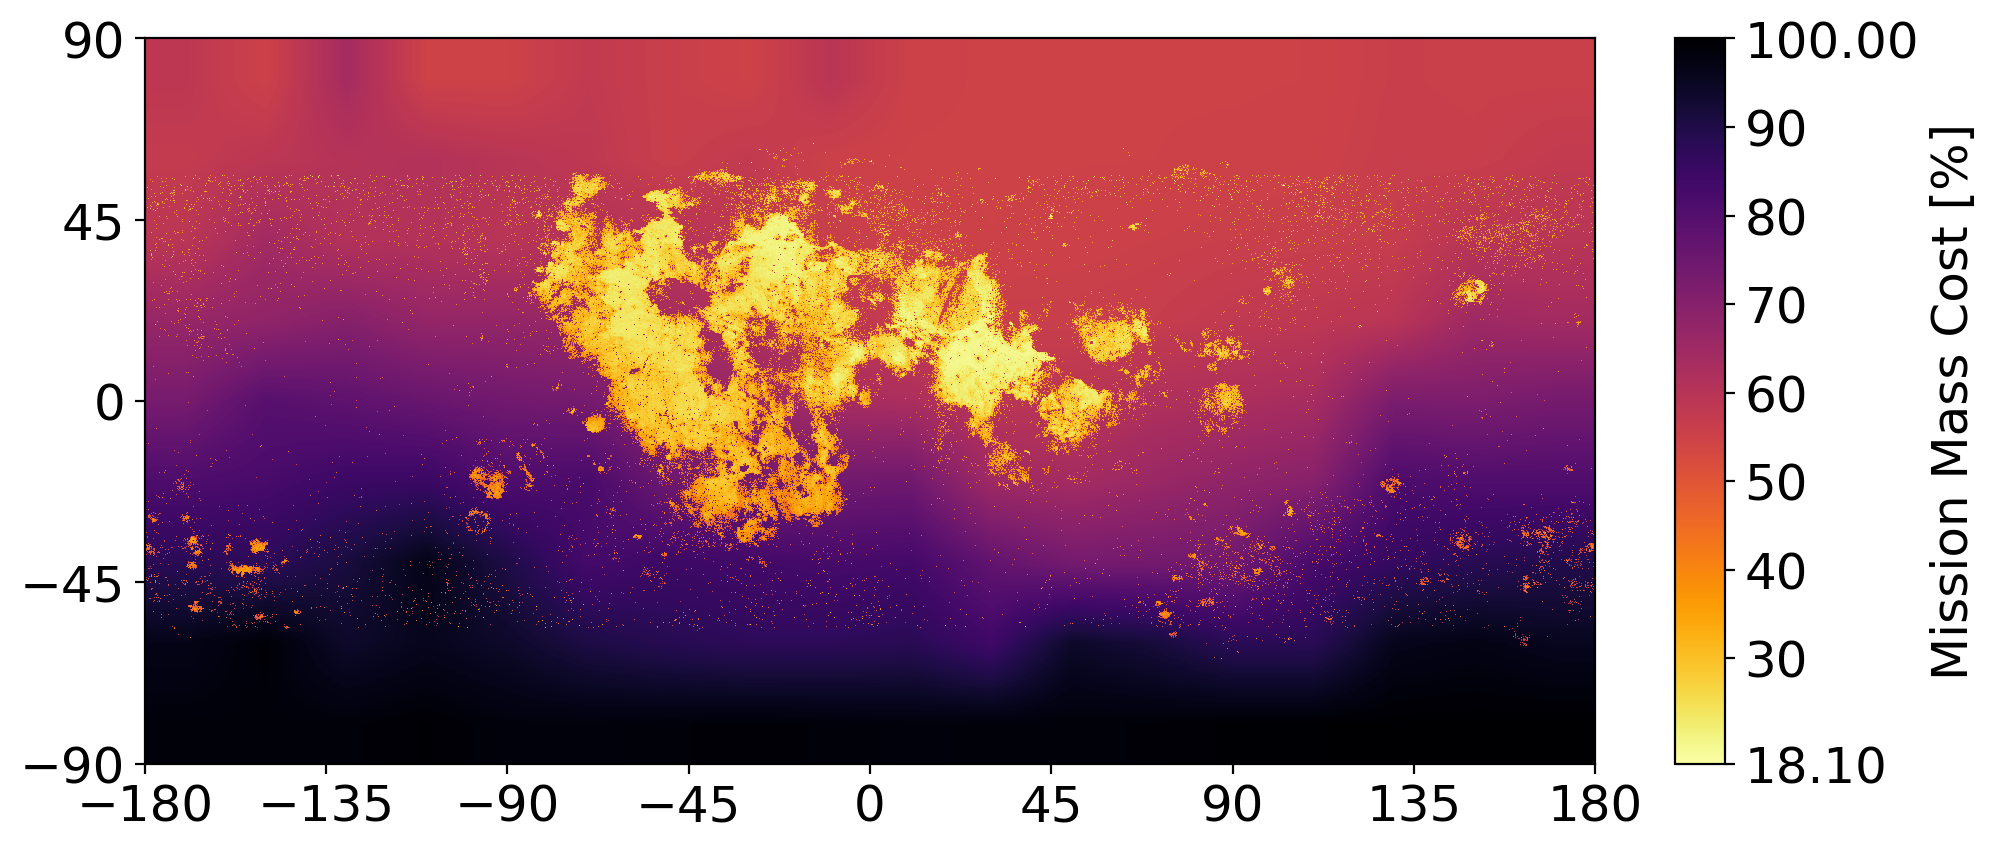

In [247]:
plot_map(Total_cost_map_advanced_1_5,np.max(Total_cost_map_advanced_1_5)/100,'Mission Mass Cost [%]',(-90,90),(-180,180),cmap=revinferno,i_steps=np.array([30,40,50,60,70,80,90])*(np.max(Total_cost_map_advanced_1_5)/100),silent=True,labelsize=18,save="Total_Cost_NRHO_1_5.pdf")

In [12]:
Total_cost_map_advanced_2_5 = total_costs_advanced_2_5(20)

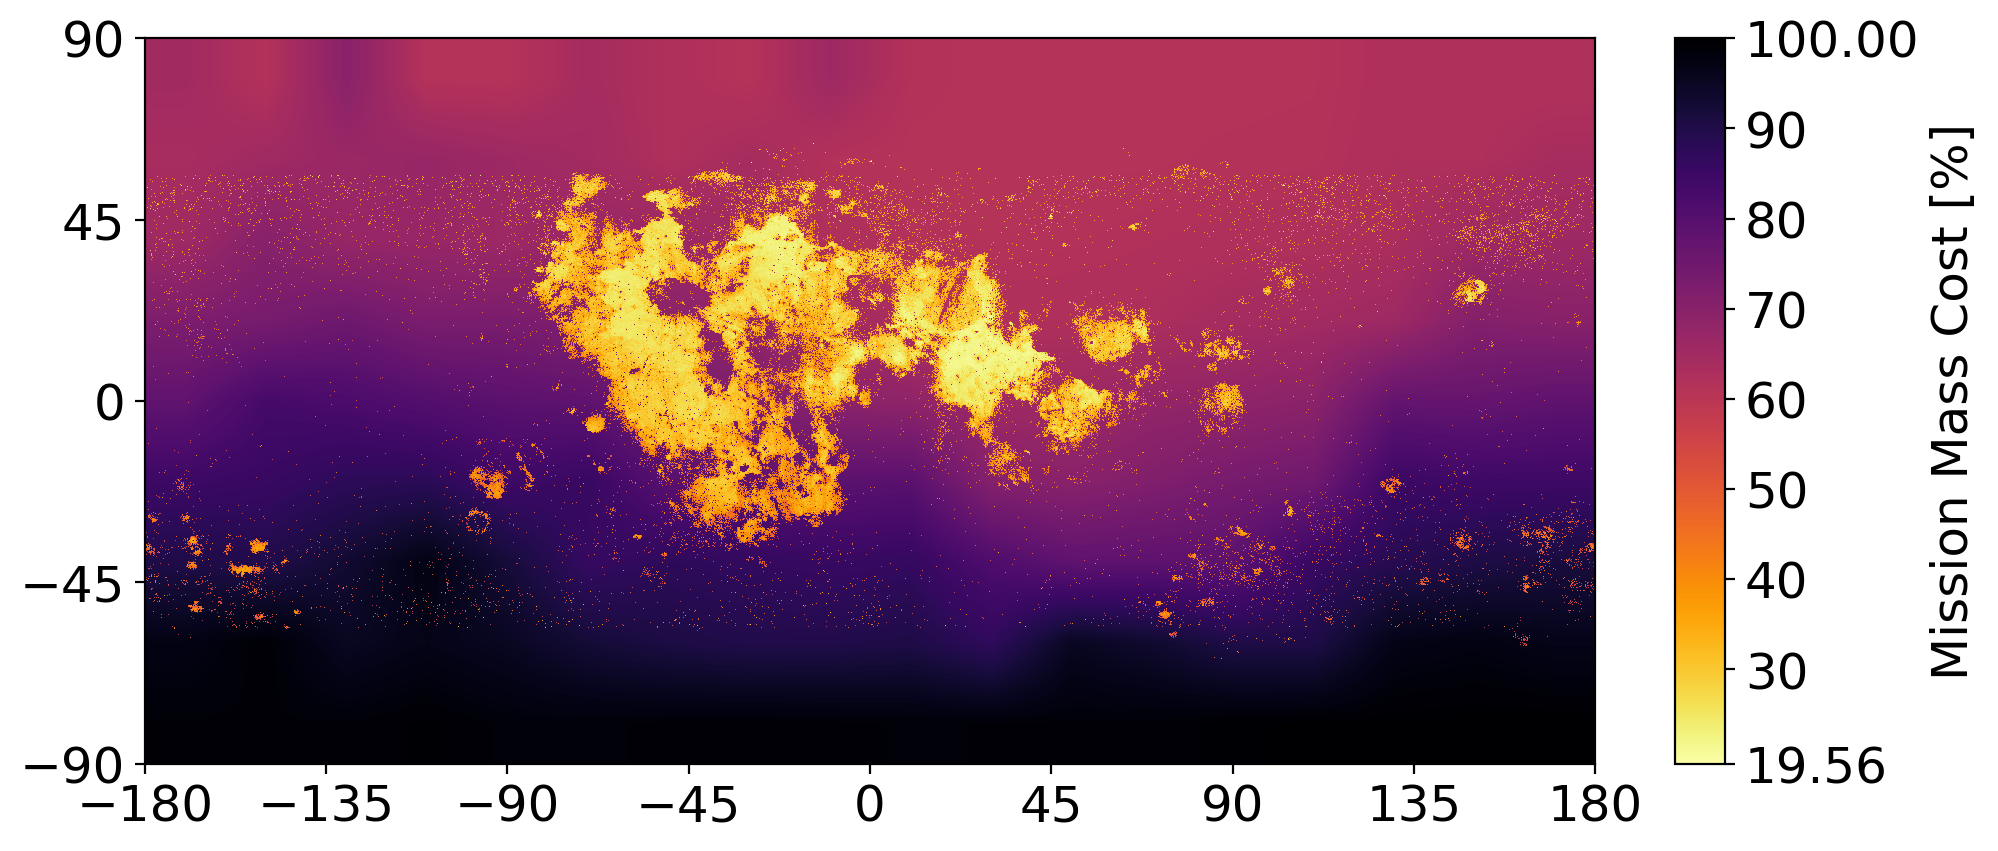

In [250]:
plot_map(Total_cost_map_advanced_2_5,np.max(Total_cost_map_advanced_2_5)/100,'Mission Mass Cost [%]',(-90,90),(-180,180),cmap=revinferno,i_steps=np.array([30,40,50,60,70,80,90])*(np.max(Total_cost_map_advanced_2_5)/100),silent=True,labelsize=18,save="Total_Cost_NRHO_2_5.pdf")

In [13]:
r_m_1 = '8.555'
r_m_2 = '10.688'

In [14]:
# Compute Fix costs and dynamic costs

x = np.linspace(0,200,100)

fix_costs_1_5 = []
fix_cost_1_5_min = np.zeros(x.shape) # ISRU cost + additional ISRU cost
fix_cost_1_5_max = np.zeros(x.shape)

dyn_costs_1_5 = []
dyn_cost_1_5_min = np.zeros(x.shape) # dynamic costs H2
dyn_cost_1_5_max = np.zeros(x.shape)

print(f'Computing fix and dynamic costs for mass ratio = {r_m_1}')
with tqdm(total=len(x)) as pbar: 
    for i, year in enumerate(x):
        fix_cost_1_5 , dyn_cost_1_5 = total_costs_advanced_1_5(year, return_splits=True)
        fix_costs_1_5.append(fix_cost_1_5)
        dyn_costs_1_5.append(dyn_cost_1_5)
        fix_cost_1_5_min[i] = np.min(fix_cost_1_5)
        fix_cost_1_5_max[i] = np.max(fix_cost_1_5)
        dyn_cost_1_5_min[i] = np.min(dyn_cost_1_5)
        dyn_cost_1_5_max[i] = np.max(dyn_cost_1_5)
        pbar.update(1)


fix_costs_2_5 = []
fix_cost_2_5_min = np.zeros(x.shape) # ISRU cost + additional ISRU cost
fix_cost_2_5_max = np.zeros(x.shape)

dyn_costs_2_5 = []
dyn_cost_2_5_min = np.zeros(x.shape) # dynamic costs H2
dyn_cost_2_5_max = np.zeros(x.shape)

print(f'Computing fix and dynamic costs for mass ratio = {r_m_2}')
with tqdm(total=len(x)) as pbar: 
    for i, year in enumerate(x):
        fix_cost_2_5 , dyn_cost_2_5 = total_costs_advanced_2_5(year, return_splits=True)
        fix_costs_2_5.append(fix_cost_2_5)
        dyn_costs_2_5.append(dyn_cost_2_5)
        fix_cost_2_5_min[i] = np.min(fix_cost_2_5)
        fix_cost_2_5_max[i] = np.max(fix_cost_2_5)
        dyn_cost_2_5_min[i] = np.min(dyn_cost_2_5)
        dyn_cost_2_5_max[i] = np.max(dyn_cost_2_5)
        pbar.update(1)

Computing fix and dynamic costs for mass ratio = 8.555


  0%|          | 0/100 [00:00<?, ?it/s]

Computing fix and dynamic costs for mass ratio = 10.688


  0%|          | 0/100 [00:00<?, ?it/s]

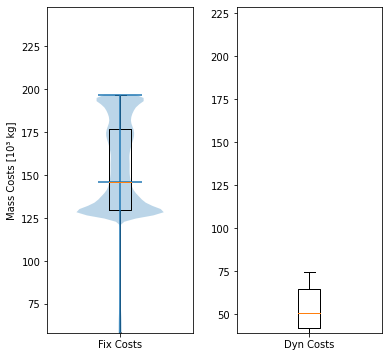

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


data = [fix_costs[2].flatten()/1000, dyn_costs[2].flatten()/1000]

# Customize outlier appearance
outlier_marker = dict(marker='o', markerfacecolor='gray', markeredgecolor='gray',
                     markersize=1, linestyle='none', alpha=0.1)

# Create a figure and gridspec
fig = plt.figure(figsize=(6, 6))
gs = GridSpec(1, 2, width_ratios=[1, 1], wspace=0.3)

# Plot fix_costs
ax_fix = fig.add_subplot(gs[0, 0])
ax_fix.boxplot(data[0], flierprops=outlier_marker)
ax_fix.violinplot(data[0], showmedians=True, widths=0.6)


q1 = np.quantile(data[0], 0.25)
q3 = np.quantile(data[0], 0.75)
iqr = q3 - q1
lower_threshold = q1 - 1.5 * iqr
upper_threshold = q3 + 1.5 * iqr

ax_fix.set_ylim(lower_threshold, upper_threshold)
delta = upper_threshold - lower_threshold
ax_fix.set_ylabel('Mass Costs [10³ kg]')

# Plot dyn_costs
ax_dyn = fig.add_subplot(gs[0, 1])
ax_dyn.boxplot(data[1], flierprops=outlier_marker)
ax_dyn.set_ylim(np.min(data[1]), np.min(data[1])+delta)

# Remove x-axis tick labels from fix_costs
ax_fix.set_xticklabels(['Fix Costs'])
ax_dyn.set_xticklabels(['Dyn Costs'])


plt.show()


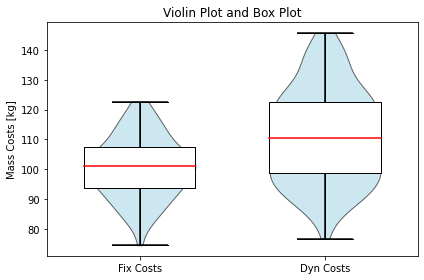

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# Generate sample data
np.random.seed(0)
dataset_fix = np.random.normal(100, 10, size=(100,))
dataset_dyn = np.random.normal(110, 15, size=(100,))

# Create a figure and axes
fig, ax = plt.subplots()

# Customize outlier appearance
outlier_marker = dict(marker='o', markerfacecolor='gray', markeredgecolor='gray',
                     markersize=1, linestyle='none', alpha=0.5)

# Create the violin plot
violin_parts = ax.violinplot([dataset_fix, dataset_dyn], showmedians=True, widths=0.6)

# Customize violin plot colors
for pc in violin_parts['bodies']:
    pc.set_facecolor('lightblue')
    pc.set_edgecolor('black')
    pc.set_alpha(0.6)

violin_parts['cbars'].set_color('black')
violin_parts['cmedians'].set_color('red')
violin_parts['cmaxes'].set_color('black')
violin_parts['cmins'].set_color('black')

# Create the box plot
box_parts = ax.boxplot([dataset_fix, dataset_dyn], positions=[1, 2], widths=0.6, patch_artist=True, flierprops=outlier_marker)

# Customize box plot colors
for box in box_parts['boxes']:
    box.set(facecolor='white', edgecolor='black')
for whisker in box_parts['whiskers']:
    whisker.set(color='black', linestyle='-', linewidth=1)
for cap in box_parts['caps']:
    cap.set(color='black', linewidth=1)
for median in box_parts['medians']:
    median.set(color='red', linewidth=1.5)
for flier in box_parts['fliers']:
    flier.set(marker='o', markerfacecolor='gray', markeredgecolor='gray', markersize=1, alpha=0.5, linestyle='none')

# Set labels and title
ax.set_xticks([1, 2])
ax.set_xticklabels(['Fix Costs', 'Dyn Costs'])
ax.set_ylabel('Mass Costs [kg]')
ax.set_title('Violin Plot and Box Plot')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()


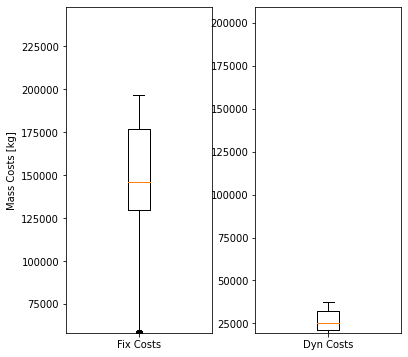

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


data = [fix_costs[1].flatten(), dyn_costs[1].flatten()]

# Create a figure and gridspec
fig = plt.figure(figsize=(6, 6))
gs = GridSpec(1, 2, width_ratios=[1, 1], wspace=0.3)

# Plot fix_costs
ax_fix = fig.add_subplot(gs[0, 0])
ax_fix.boxplot(data[0])


q1 = np.quantile(data[0], 0.25)
q3 = np.quantile(data[0], 0.75)
iqr = q3 - q1
lower_threshold = q1 - 1.5 * iqr
upper_threshold = q3 + 1.5 * iqr

ax_fix.set_ylim(lower_threshold, upper_threshold)
delta = upper_threshold - lower_threshold
ax_fix.set_ylabel('Mass Costs [kg]')

# Plot dyn_costs
ax_dyn = fig.add_subplot(gs[0, 1])
ax_dyn.boxplot(data[1])
ax_dyn.set_ylim(np.min(data[1]), np.min(data[1])+delta)

# Remove x-axis tick labels from fix_costs
ax_fix.set_xticklabels(['Fix Costs'])
ax_dyn.set_xticklabels(['Dyn Costs'])


plt.show()


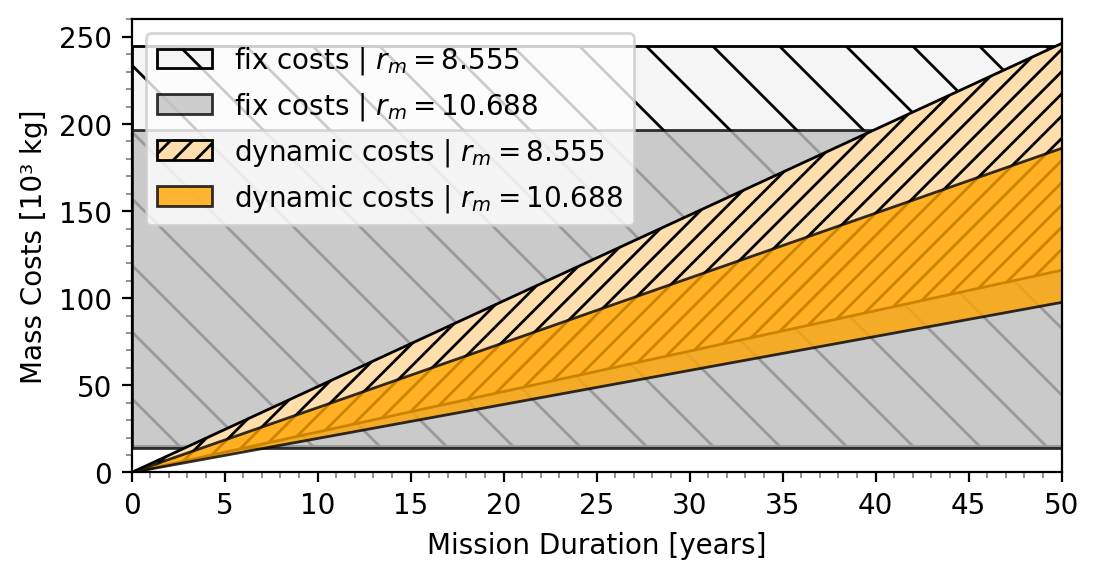

In [25]:
plt.figure(figsize=(6,3), dpi=200)
#plt.title("Cost components")
divider = 1000

# 1_5
#plt.plot(x,fix_cost_1_5_min/divider,color='tab:blue',linewidth=0.5)
#plt.plot(x,fix_cost_1_5_max/divider,color='tab:blue',linewidth=0.5)
plt.fill_between(x,fix_cost_1_5_min[0]/divider, fix_cost_1_5_max[0]/divider, color='whitesmoke', hatch='\\', edgecolor='black',alpha=1, label=f'fix costs | $r_m={r_m_1}$')

# 2_0
#plt.plot(x,fix_cost_2_5_min/divider,color='tab:blue',linewidth=0.5)
#plt.plot(x,fix_cost_2_5_max/divider,color='tab:blue',linewidth=0.5)
plt.fill_between(x,fix_cost_2_5_min[0]/divider, fix_cost_2_5_max[0]/divider, color='silver', hatch='', edgecolor='black',alpha=0.8, label=f'fix costs | $r_m={r_m_2}$')

# 1_5
#plt.plot(x,dyn_cost_1_5_min/divider,color='tab:orange',linewidth=0.5)
#plt.plot(x,dyn_cost_1_5_max/divider,color='tab:orange',linewidth=0.5)
plt.fill_between(x,dyn_cost_1_5_min/divider, dyn_cost_1_5_max/divider,color='navajowhite', hatch='///', edgecolor='black',alpha=1,  label=f'dynamic costs | $r_m={r_m_1}$')

# 2_0
#plt.plot(x,dyn_cost_2_5_min/divider,color='tab:orange',linewidth=0.5)
#plt.plot(x,dyn_cost_2_5_max/divider,color='tab:orange',linewidth=0.5)
plt.fill_between(x,dyn_cost_2_5_min/divider, dyn_cost_2_5_max/divider, color='orange', hatch='', edgecolor='black',alpha=0.8, label=f'dynamic costs | $r_m={r_m_2}$')

plt.ylim(0,260)
plt.xlim(0,50)
plt.legend(loc='upper left')
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(10))

ax.tick_params(axis='x', which='minor', colors='0.5')
ax.tick_params(axis='y', which='minor', colors='0.5')

plt.ylabel("Mass Costs [10³ kg]")
plt.xlabel("Mission Duration [years]")
plt.savefig('doc/img/cost_components.pdf', dpi=300,facecolor ='white', bbox_inches='tight',pad_inches = 0)
plt.show()

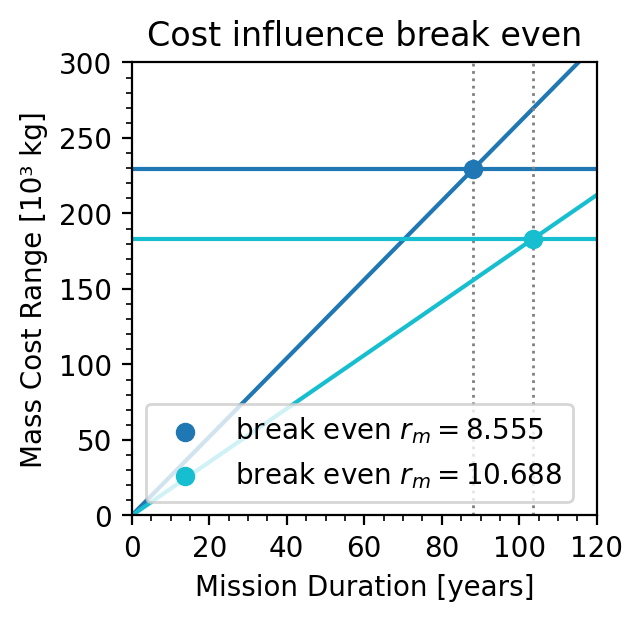

In [16]:
divider = 1000

plt.figure(figsize=(3,3), dpi=200)
plt.title("Cost influence break even")

plt.plot(x,(fix_cost_1_5_max - fix_cost_1_5_min)/divider,color='tab:blue') # ISRU range
plt.plot(x,(dyn_cost_1_5_max - dyn_cost_1_5_min)/divider,color='tab:blue') # Transport range
breakeven_1_5 = 88.1
plt.scatter(breakeven_1_5,((fix_cost_1_5_max - fix_cost_1_5_min)/divider)[0],color='tab:blue',zorder=5,label=f'break even $r_m={r_m_1}$')
plt.axvline(x=breakeven_1_5 ,linewidth=1, color='0.5',linestyle=":")

#print((fix_cost_1_5_max - fix_cost_1_5_min))
#breakeven_1_5 = (fix_cost_1_5_max - fix_cost_1_5_min) (dyn_cost_1_5_max - dyn_cost_1_5_min)

plt.plot(x,(fix_cost_2_5_max - fix_cost_2_5_min)/divider,color='tab:cyan') # ISRU range
plt.plot(x,(dyn_cost_2_5_max - dyn_cost_2_5_min)/divider,color='tab:cyan') # Transport range
breakeven_2_5 = 103.5
plt.scatter(breakeven_2_5,((fix_cost_2_5_max - fix_cost_2_5_min)/divider)[0],color='tab:cyan',zorder=5,label=f'break even $r_m={r_m_2}$')
plt.axvline(x=breakeven_2_5 ,linewidth=1, color='0.5',linestyle=":")


#plt.xlim(0,1000)
#plt.xlim(0,20)
plt.ylim(0,300)
plt.xlim(0,120)
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(20))
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(10))
#ax.yaxis.set_major_locator(MultipleLocator(1))
plt.legend(loc='lower left')
plt.ylabel("Mass Cost Range [10³ kg]")
plt.xlabel("Mission Duration [years]")
plt.savefig('doc/img/breakeven.pdf', dpi=300,facecolor ='white', bbox_inches='tight',pad_inches = 0)
plt.show()
# after 2080 years it has a higher influence range